[[    0.       14.        0.   ]
 [    0.     9333.33      0.   ]
 [    0.       14.        0.   ]
 [    0.    -9333.333     0.   ]]
Global Stiffness Matrix [[ 1400000.           700000.                0.           700000.
   -700000.                0.                0.                0.        ]
 [  700000.          2450000.           525000.           700000.
   -306250.          -393750.                0.                0.        ]
 [       0.           525000.          3150000.                0.
    393750.          1181250.         -1575000.          1050000.        ]
 [  700000.           700000.                0.           466666.66666667
   -466666.66666667        0.                0.                0.        ]
 [ -700000.          -306250.           393750.          -466666.66666667
    663541.66666667  -196875.                0.                0.        ]
 [       0.          -393750.          1181250.                0.
   -196875.          1771875.         -1575000.         

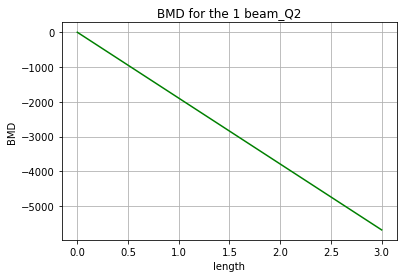

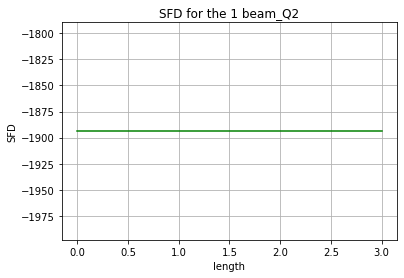

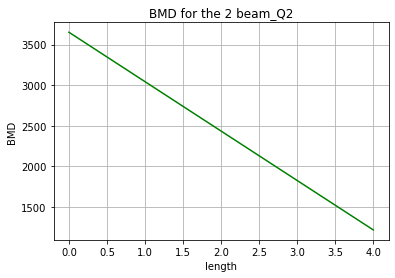

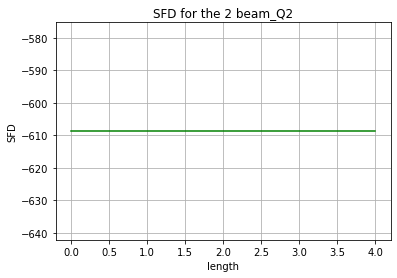

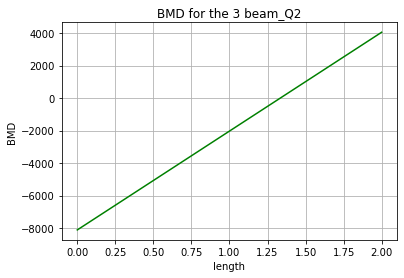

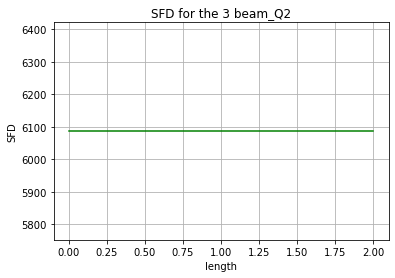

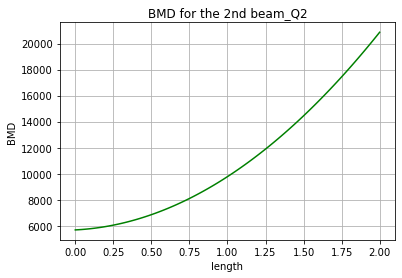

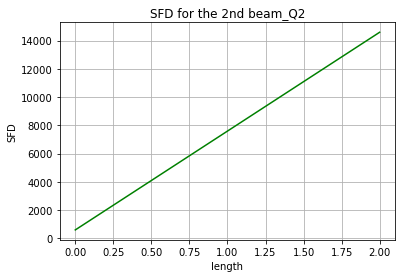

Member Displacement [[ 0.          0.          0.        ]
 [ 0.00270531 -0.00541063  0.00386473]
 [ 0.          0.          0.        ]
 [-0.00541063  0.00386473  0.        ]]
Member Forces [[-1893.71973913  -594.69563043  6086.95630435]
 [    0.          5681.15621739  8115.94173913]
 [ 1893.71973913   622.69563043 -6086.95630435]
 [-5681.15921739 -8115.94173913  4057.97086957]]


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
#all the free dof should be numbered first and then the constrained ones.
# all units are SI units
#boundary matrix content boundary conditions of the beam 0 if dof is free and 1 if dof is constrained
#element matrix contain material and geometric properties 1st column length,2nd Young's Modulus and 3rd moment of interia
w=7000
nbeam=3
nnodes=4
dofpernode=2
totaldof=nnodes*dofpernode
Force = np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q2\\force.txt", dtype=float)
Force_Dash = np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q2\\force_dash.txt", dtype=float)
Displacement = np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q2\\displacement.txt", dtype=float)
association_mat=np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q2\\association.txt", dtype=int)
element=np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q2\\element.txt", dtype=float)
boundary=np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q2\\boundary.txt", dtype=int)
Force=np.transpose(Force)
Force_Dash=np.transpose(Force_Dash)
print(Force_Dash)
Displacement=np.transpose(Displacement)
KTS=np.zeros((totaldof,totaldof))
markerd=np.zeros(0)
markerf=np.zeros(0)
P=np.zeros(0)
Ux=np.zeros(0)
count=0
for m in range(totaldof):
        if boundary[m]==0:
            P=np.append(P,[Force[m]],axis=0) 
            markerf=np.append(markerf,m)
            count=count+1
        else:
            Ux=np.append(Ux,[Displacement[m]],axis=0)
            markerd=np.append(markerd,m)   
P=np.transpose(P)
Ux=np.transpose(Ux)
nfree=count
nrestrained=totaldof-count  
Ke=np.zeros(((4,4,nbeam)))
for i in range(0,nbeam):
    l=element[i,0]
    E=element[i,1]
    I=element[i,2]
    a=12*E*I/(l**3)
    b=6*E*I/(l**2)
    c=4*E*I/l
    d=2*E*I/l
    Ke[:,:,i]=np.array([(a,b,-a,b),(b , c , -b ,d),(-a, -b, a, -b),(b, d, -b, c)])
    expanded_element_stiffness=np.zeros((totaldof,totaldof))
    for j in range(2*dofpernode):
        for k in range (2*dofpernode):
            expanded_element_stiffness[association_mat[i,j]-1,association_mat[i,k]-1]=Ke[j,k,i]                
    KTS=KTS+expanded_element_stiffness
print('Global Stiffness Matrix',KTS)
Kpp=KTS[0:nfree,0:nfree]
Kpx=KTS[0:nfree,nfree:totaldof]
Kxp=np.transpose(Kpx)
Kxx=KTS[nfree:totaldof,nfree:totaldof]

Kpp_inverse=np.linalg.inv(Kpp)
Up=Kpp_inverse@P-Kpp_inverse@Kpx@Ux
X=Kxp@Up+Kxx@Ux-Force[nfree:totaldof]

Displacement=np.concatenate((Up, Ux), axis=0)
Force=np.concatenate((P, X), axis=0)
print('Force Matrix',Force)
print('Displacement Matrix',Displacement)
u=np.zeros((2*dofpernode,nbeam)) 
f=np.zeros((2*dofpernode,nbeam))
                        
for i in range(0,nbeam):
    for j in range(0,2*dofpernode):
        u[j,i]=Displacement[association_mat[i,j]-1]
    f[:,i]=Ke[:,:,i]@u[:,i]+Force_Dash[:,i]
    l=element[i,0]
    E=element[i,1]
    I=element[i,2]
    a=((2*(u[0,i]-u[2,i])/(l**3))+(u[1,i]+u[3,i])/(l**2))*E*I
    b=((-3*(u[0,i]-u[2,i])/l**2)-(2*u[1,i]+u[3,i])/l)*E*I
    c=6*a
    d=2*b
    x = np.linspace(0, l,100)
    y =  (c * x) + d
    plt.plot(x, y, '-g', label=r'BMD')
    plt.xlabel('length')
    plt.ylabel('BMD')
    plt.title("BMD for the %i beam_Q2"%(i+1))
    plt.grid(True)
    plt.show()
    x = np.linspace(0, l,100)
    y =  c+0*x
    plt.plot(x, y, '-g', label=r'SFD')
    plt.xlabel('length')
    plt.ylabel('SFD')
    plt.title("SFD for the %i beam_Q2"%(i+1))
    plt.grid(True)
    plt.show()
#for beam 2 
x = np.linspace(0, l,100)
y = f[1,1]-f[0,1]*x+w*x*x/2
plt.plot(x, y, '-g', label=r'BMD')
plt.xlabel('length')
plt.ylabel('BMD')
plt.title("BMD for the 2nd beam_Q2")
plt.grid(True)
plt.show()
x = np.linspace(0, l,100)
y = -f[0,1]+w*x
plt.plot(x, y, '-g', label=r'SFD')
plt.xlabel('length')
plt.ylabel('SFD')
plt.title("SFD for the 2nd beam_Q2")
plt.grid(True)
plt.show()
print('Member Displacement',u)
print('Member Forces',f)   